# Introduction

Our team, D1D, joined prohack, our first data science hackathon and we are very pleased from this experience, we were ranked 4th on public LB and 25th on private one, we took this drop because of the way our 2nd task is constructed which will be explained on the 2nd notebook

This notebook explains the EDA, preproceessing and the modeling for our solution to the 1st task.

## A Bit About Prohack

Prohack is a data science competition organized by McKinsey and company which took place from  May 18th to June 21st. There were 2 tasks: a regression task and an optimization task. This notebook is about the 1st task which represents 80% of the RMSE. 

The public LB is calculated through 80% of the test set and 20% is left for the private one.

# EDA:

## Dataset exploration:

The dataset contains two csv files: train and test.csv, 80 features on trains csv with one categorical variable named galaxy. 3200 rows on the train set and 890 rows on the test set.

There are 180 unique galaxies, each galaxy has between 24 to 27 rows of data (train and test set combined), each row represent a galactic year (one year).

We believe that the data has been taken from UNDP data and noise was added and some obfuscation was made in order to not be able to get the clean dataset, even though this is possible, it is quite hard to find matching patterns between the provided dataset and the real one from UNDP so wee decided to not take this route.



In [17]:
# Installing Catboost and vecstack (a stacking library)
!pip install catboost
!pip install vecstack

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso

# LGBM, XGB, CTB
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Stacking library
from vecstack import StackingTransformer

In [19]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
all_df = pd.concat([train,test]).reset_index()

In [20]:
print("train shape",train.shape)
print("test shape:",test.shape)
print("full dataset shape",all_df.shape)

train shape (3865, 80)
test shape: (890, 79)
full dataset shape (4755, 81)


## Exploring the dataset - Missing Values

First thing we notice, is the very large number of missing values, almost every column has missing values, GII (gender inequality index) is the one with most missing values and existance expectancy index is the feature with less NaNs (this feature is like life expectancy index devined by UNDP).



In [21]:

# Percent of NA in dataset
all_df.isna().sum().sort_values()/len(all_df)

index                                                                        0.000000
galactic year                                                                0.000000
galaxy                                                                       0.000000
existence expectancy index                                                   0.001262
existence expectancy at birth                                                0.001262
                                                                               ...   
Intergalactic Development Index (IDI), male, Rank                            0.696951
Adjusted net savings                                                         0.699054
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total    0.700736
Private galaxy capital flows (% of GGP)                                      0.703470
Gender Inequality Index (GII)                                                0.711251
Length: 81, dtype: float64

Several columns have more than 50% of missing NaNs and we can't afford to drop them since our dataset is already small and we would loose too much data, so we need to find a good way to fill NaNs. we will talk about this in the processing part.

## Exploring the dataset - Outliers

We didn't focus much on the outliers in our approach since we used gradient boosted trees that are kind of robust to outliers, however, treating outliers well will help improve results. 

All we did was to notice that there some negative values and percent higher than 1 (or 100%). we converted every negative entry to 0. But converting it to the galaxy mean would have been a better approach in our opinion.

In [22]:
all_num = all_df._get_numeric_data()
print(all_num[all_num<0].sum())

index                                                                           0.000000
galactic year                                                                   0.000000
existence expectancy index                                                      0.000000
existence expectancy at birth                                                   0.000000
Gross income per capita                                                      -126.906522
                                                                                ...     
Adjusted net savings                                                        -1359.504992
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total      -1.860236
Private galaxy capital flows (% of GGP)                                     -2495.540553
Gender Inequality Index (GII)                                                   0.000000
y                                                                               0.000000
Length: 80, dtype: fl

## Exploring the target variable

The target variable is continuous and between 0 and 1, as you can from the histogram, y is highly skewed so we might consider working with a transformation like -log(y), log1p(y) or directly applying box-cox test to find the best transformation to reduce the skewness. 

However in practice, **this didn't improve much the CV score nor the LB score** so we kept using y with no transformation.

(array([7.830e+02, 2.018e+03, 3.510e+02, 1.450e+02, 2.120e+02, 1.730e+02,
        7.700e+01, 3.000e+01, 3.100e+01, 2.100e+01, 1.300e+01, 1.000e+00,
        2.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.01303645, 0.04657526, 0.08011407, 0.11365288, 0.14719169,
        0.1807305 , 0.21426931, 0.24780812, 0.28134693, 0.31488574,
        0.34842455, 0.38196336, 0.41550217, 0.44904098, 0.48257979,
        0.5161186 , 0.54965741, 0.58319622, 0.61673503, 0.65027385,
        0.68381266]),
 <a list of 20 Patch objects>)

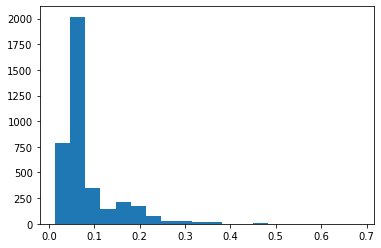

In [23]:
plt.hist(train.y,bins=20)

(array([2.000e+00, 5.000e+00, 7.000e+00, 3.400e+01, 5.300e+01, 1.050e+02,
        2.090e+02, 1.910e+02, 1.000e+02, 1.880e+02, 1.900e+02, 4.700e+02,
        8.160e+02, 1.043e+03, 2.860e+02, 7.000e+01, 4.600e+01, 3.300e+01,
        1.600e+01, 1.000e+00]),
 array([0.38007129, 0.57806802, 0.77606475, 0.97406148, 1.17205821,
        1.37005494, 1.56805167, 1.76604839, 1.96404512, 2.16204185,
        2.36003858, 2.55803531, 2.75603204, 2.95402876, 3.15202549,
        3.35002222, 3.54801895, 3.74601568, 3.94401241, 4.14200913,
        4.34000586]),
 <a list of 20 Patch objects>)

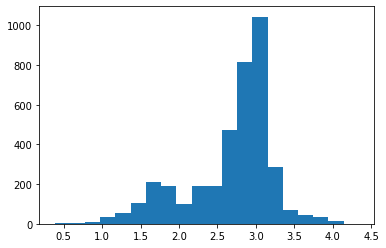

In [24]:
plt.hist(-np.log(train.y),bins=20)

((array([-3.56878042, -3.32933007, -3.1971417 , ...,  3.1971417 ,
          3.32933007,  3.56878042]),
  array([0.01303645, 0.0159289 , 0.01635177, ..., 0.55048368, 0.67683339,
         0.68381266])),
 (0.052709649427404394, 0.08277313210376175, 0.830591461087757))

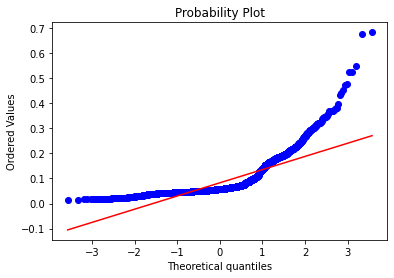

In [12]:
# QQ Plot: always useful ;)
from scipy.stats import probplot

probplot(train.y,dist="norm",plot=plt)


**Plotting y for each galaxy**

Andromeda Galaxy (M31)


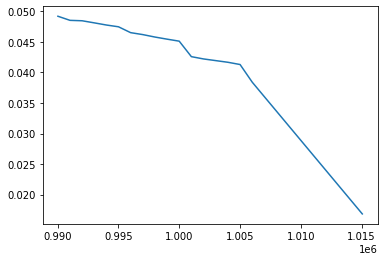

Andromeda I


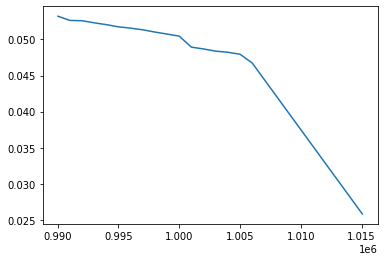

Andromeda II


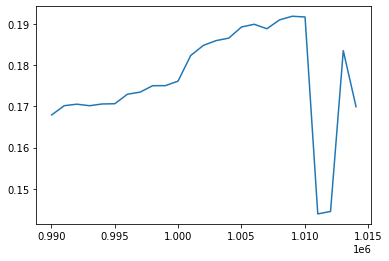

Andromeda III


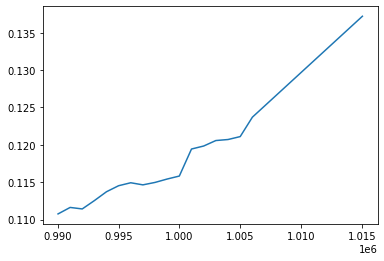

Andromeda IX


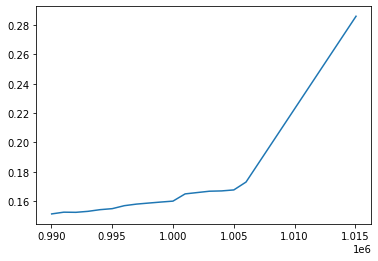

Andromeda V


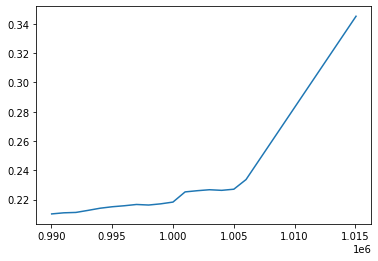

Andromeda VIII


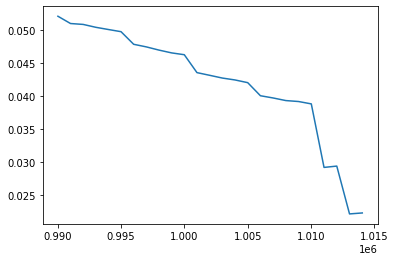

Andromeda X


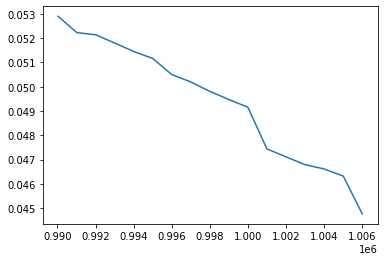

Andromeda XI


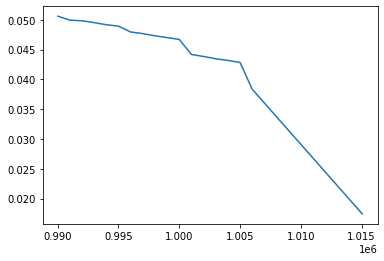

Andromeda XII


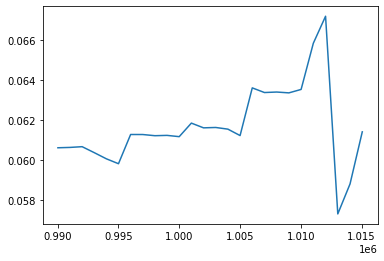

Andromeda XIX[60]


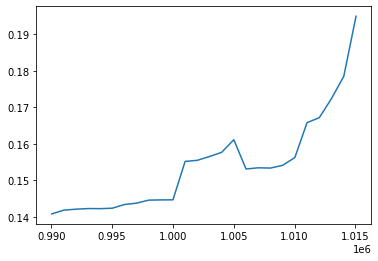

Andromeda XV


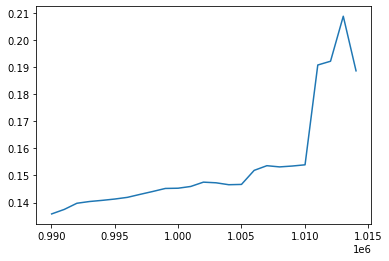

Andromeda XVII


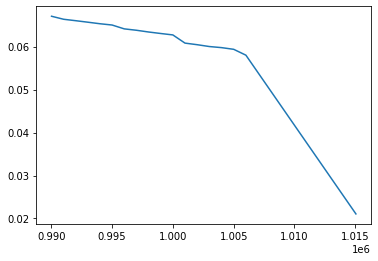

Andromeda XVIII[60]


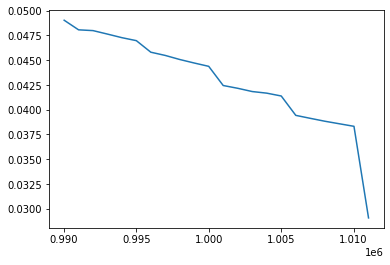

Andromeda XX


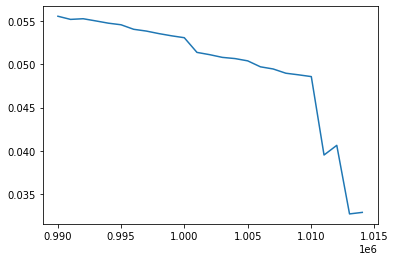

Andromeda XXIII


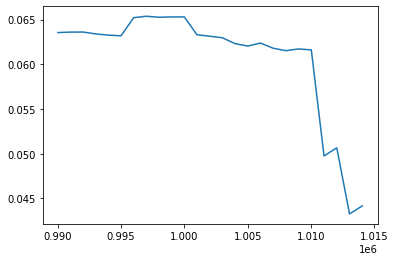

Andromeda XXII[57]


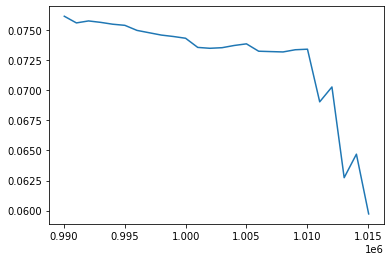

Andromeda XXIV


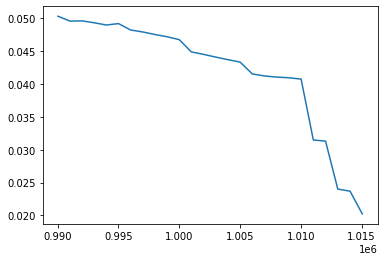

Andromeda XXIX


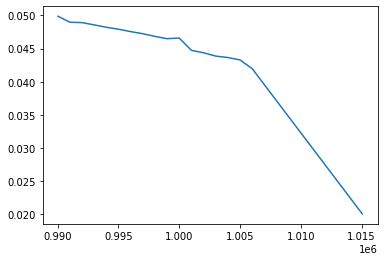

Andromeda XXI[57]


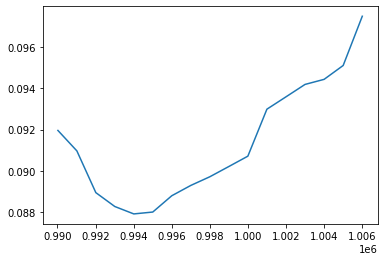

Andromeda XXV


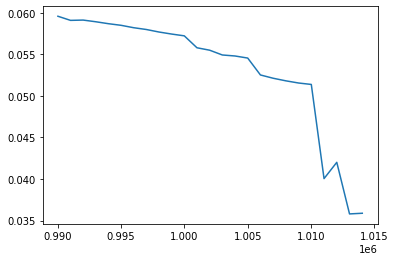

Andromeda XXVI


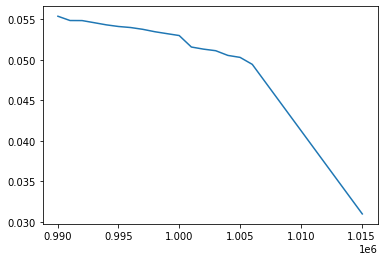

Andromeda XXVIII


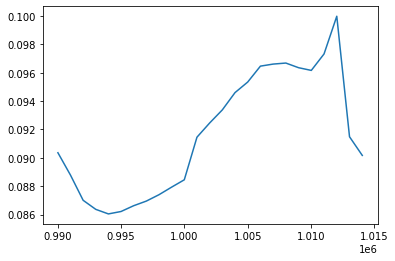

Antlia 2


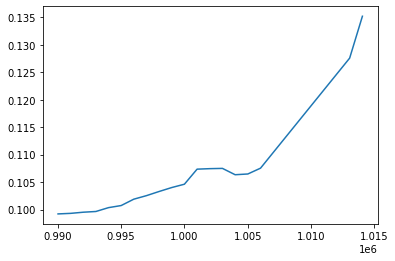

Antlia B


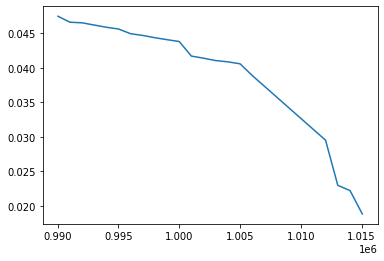

Antlia Dwarf


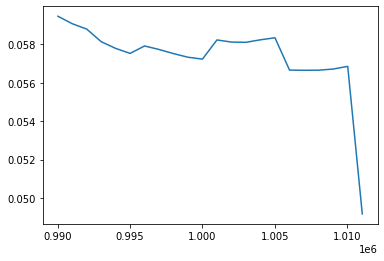

Aquarius Dwarf Galaxy (DDO 210)


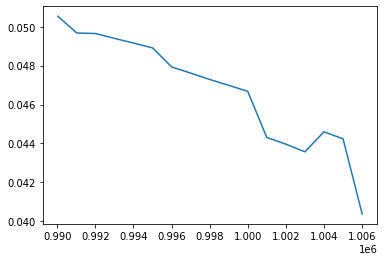

Aquarius II


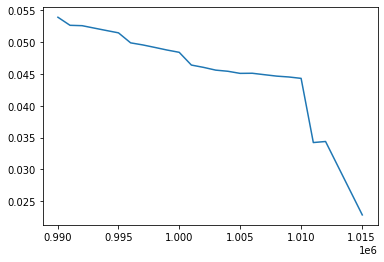

Barnard's Galaxy (NGC 6822)


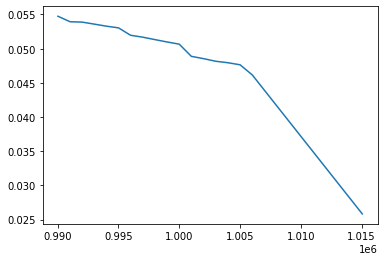

Boötes I


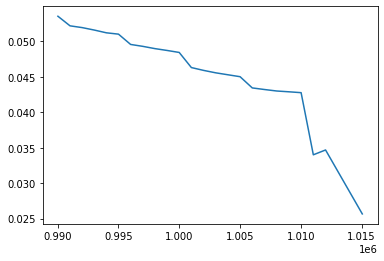

Boötes II


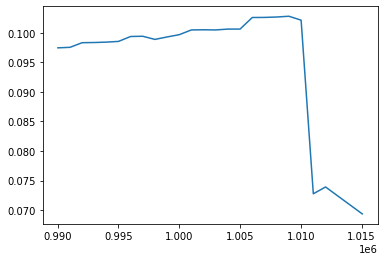

Boötes III


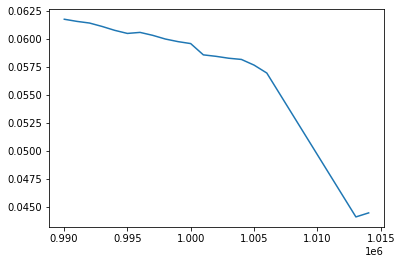

Boötes IV


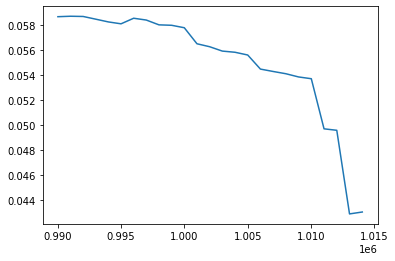

Camelopardalis B


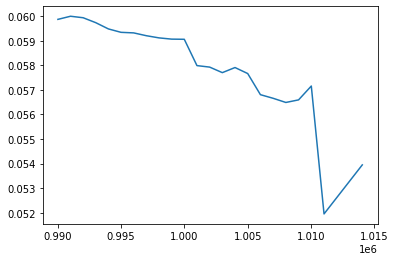

Canes Venatici I Dwarf


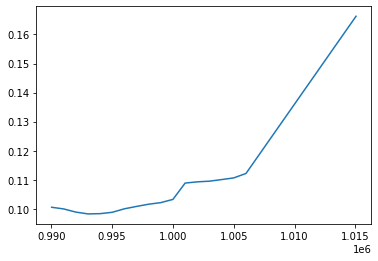

Canes Venatici II Dwarf


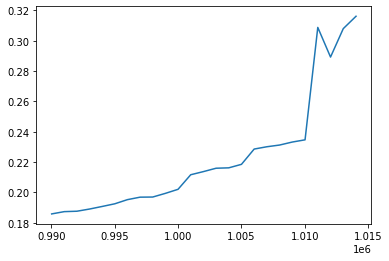

Carina Dwarf (E206-G220)


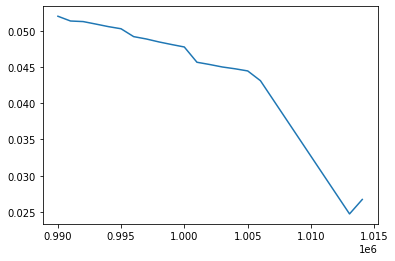

Carina II


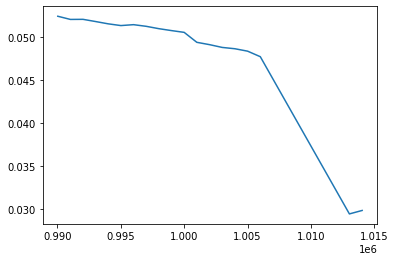

Carina III


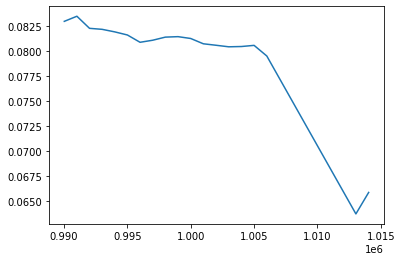

Cas 1 (KK98 19)


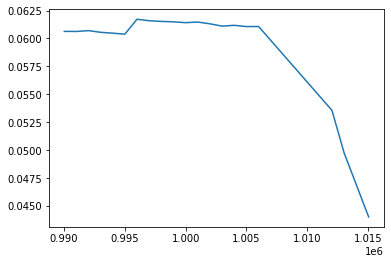

Cassiopeia Dwarf (Cas dSph, Andromeda VII)


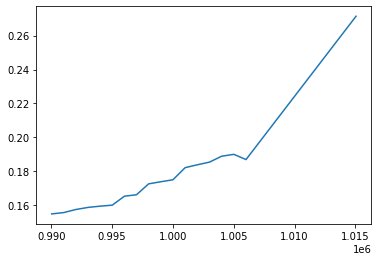

Cassiopeia II (Andromeda XXX)


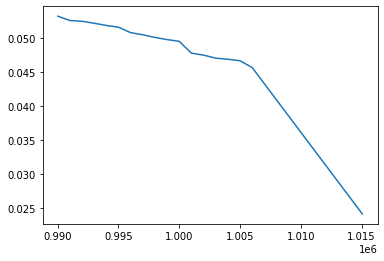

Cassiopeia III (Andromeda XXXII)


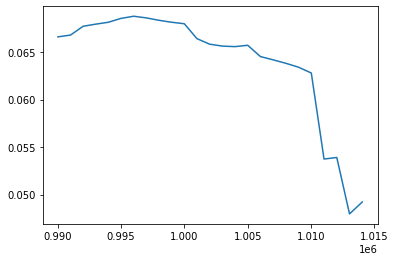

Cetus Dwarf


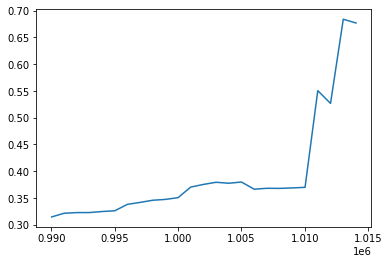

Cetus III


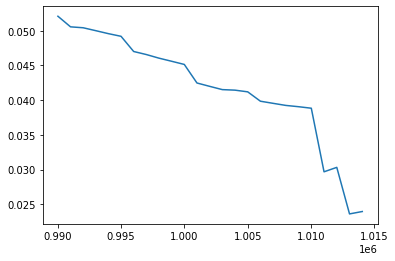

Columba I


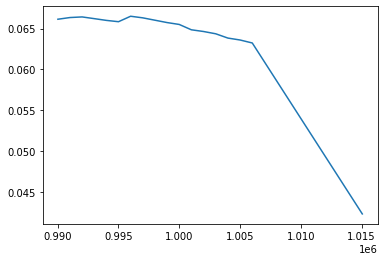

Coma Berenices Dwarf


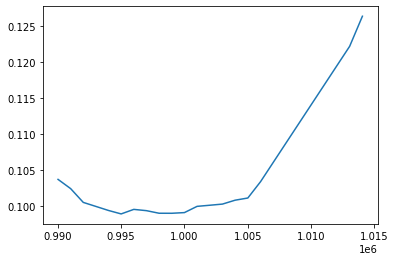

Crater II


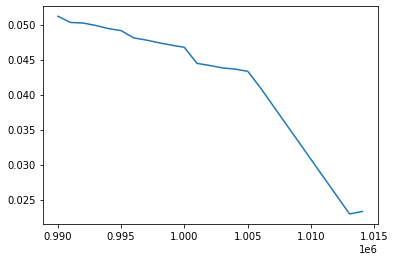

DDO 99 (UGC 6817)


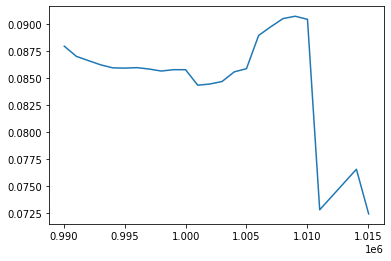

Donatiello I


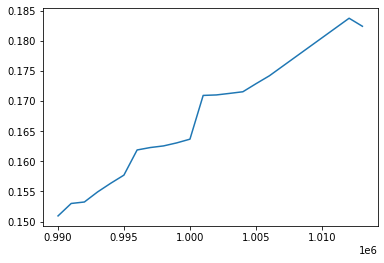

Draco Dwarf (DDO 208)


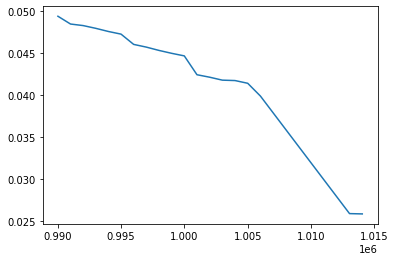

Draco II


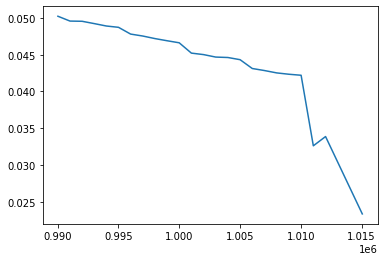

Dwingeloo 1


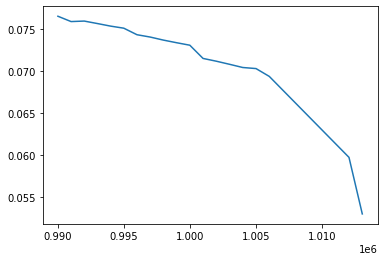

Dwingeloo 2


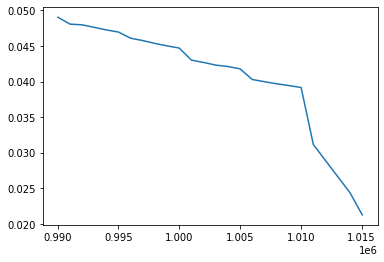

ESO 274-01[70]


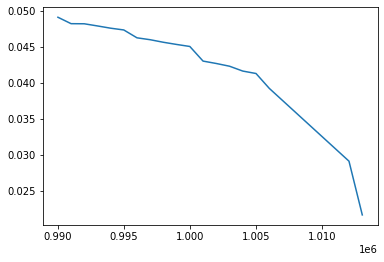

ESO 294-010


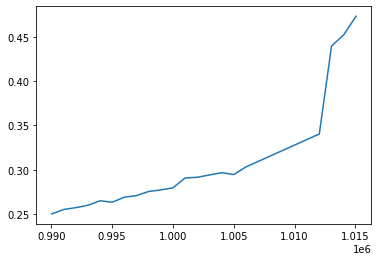

ESO 321-014[70]


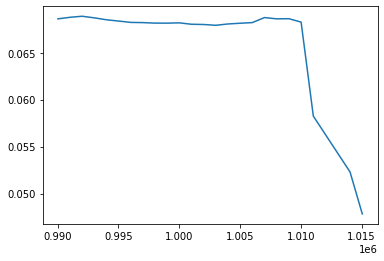

ESO 325-11


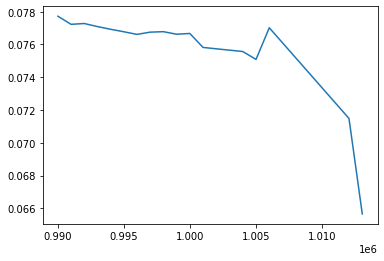

ESO 383-087 (ISG 39)


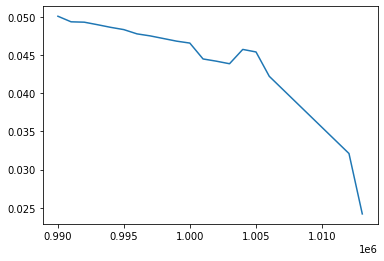

ESO 410-G005


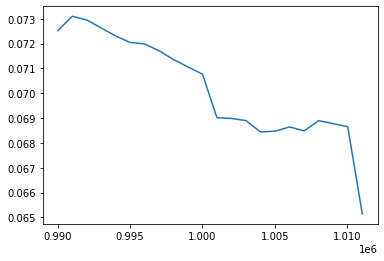

ESO 540-030 (KDG 2)


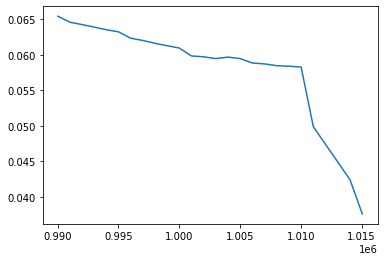

ESO 540-032


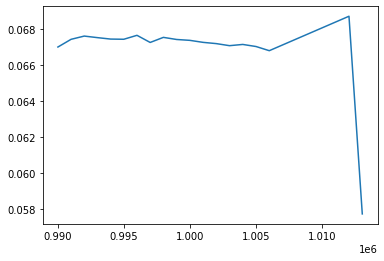

Eridanus II


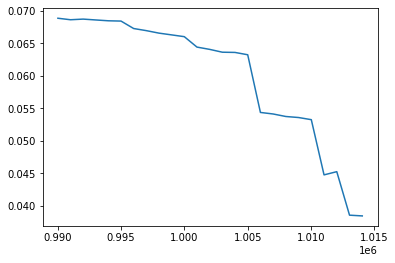

FM2000 1


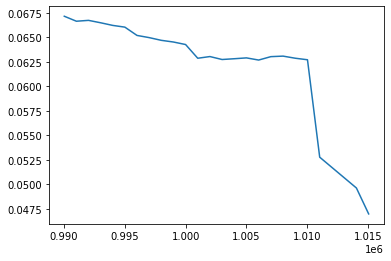

Fornax Dwarf (E356-G04)


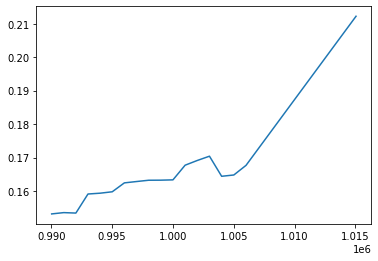

GR 8 (DDO 155)


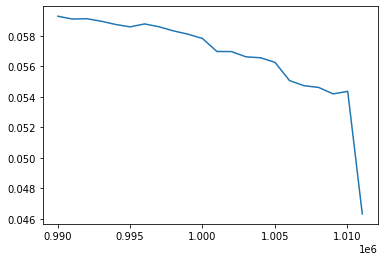

Grus I


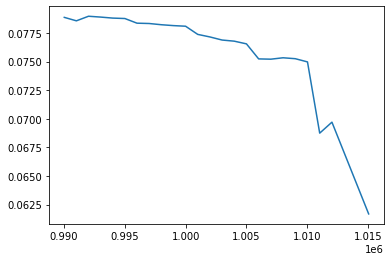

Grus II


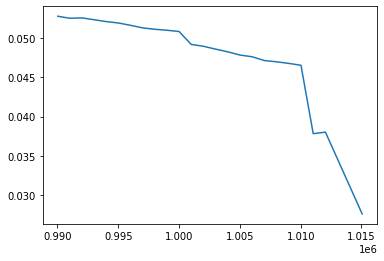

HIPASS J1247-77


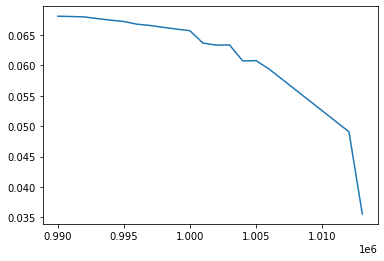

HIZSS 003


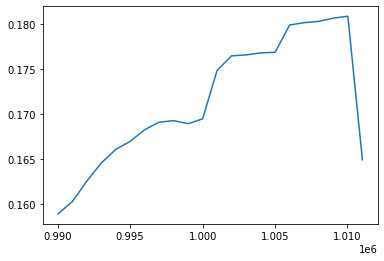

Hercules Dwarf


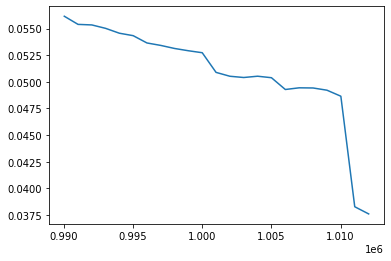

Holmberg II (DDO 50, UGC 4305)


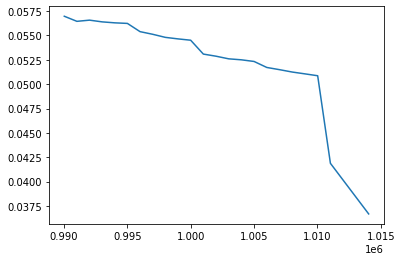

Horologium I


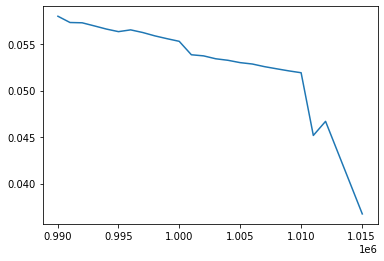

Horologium II


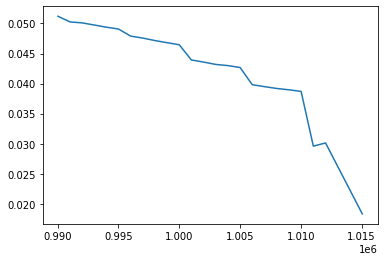

Hydra II


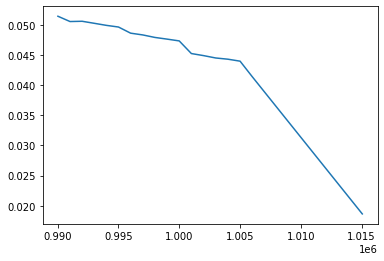

Hydrus I


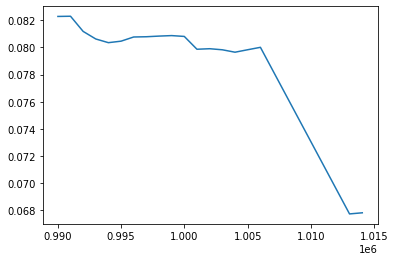

IC 10 (UGC 192)


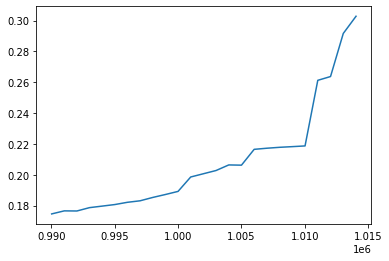

IC 1613 (UGC 668)


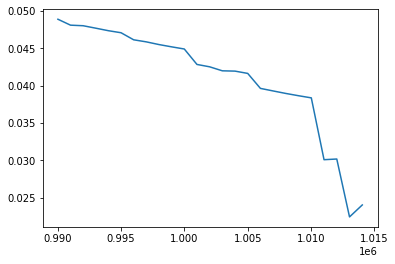

IC 3104


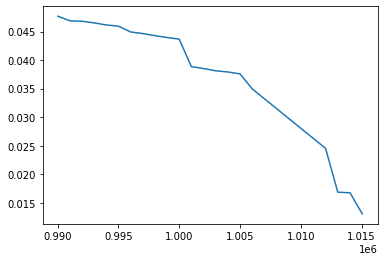

IC 342


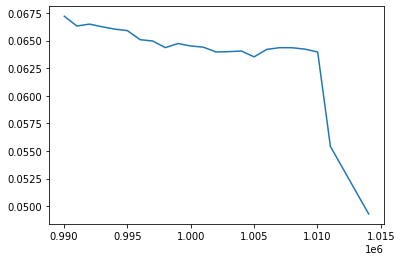

IC 4662 (ESO 102-14)


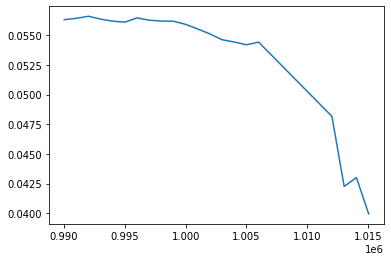

IC 5152


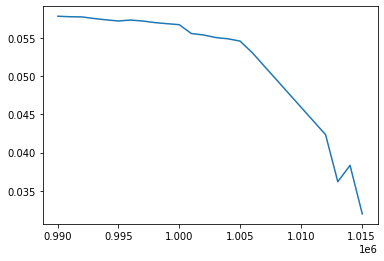

Indus II


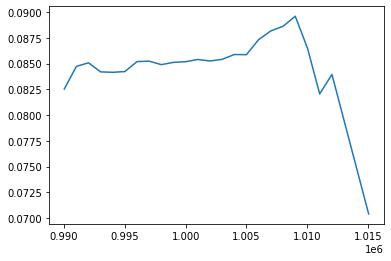

KK98 35


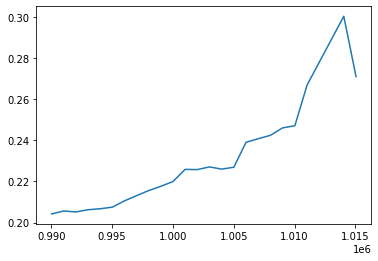

KK98 77


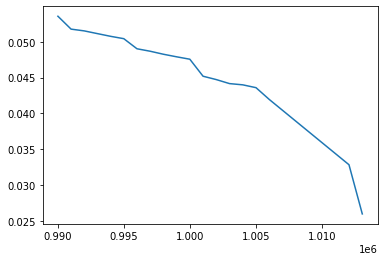

KKH 11 (ZOAG G135.74-04.53)


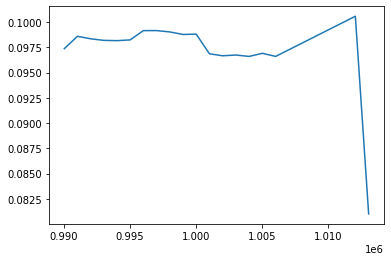

KKH 12


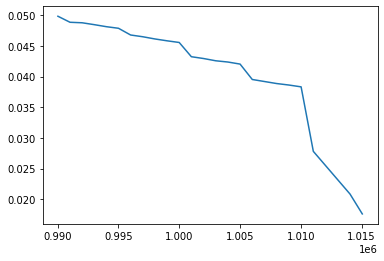

KKH 37 (Mai 16)


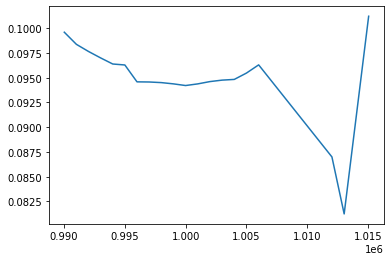

KKR 03 (KK98 230)


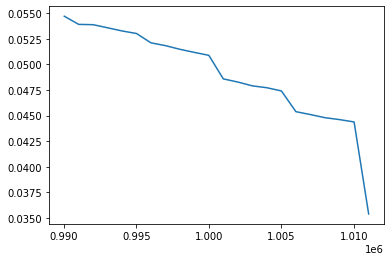

KKR 25


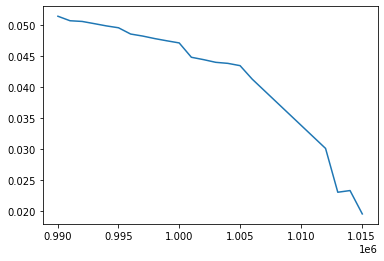

KKh 060


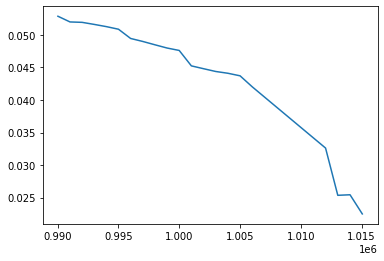

KKh 086


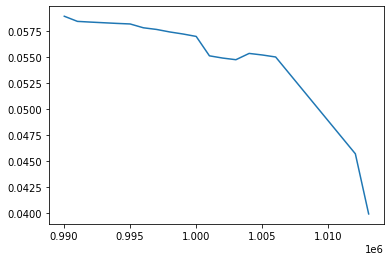

KKh 98


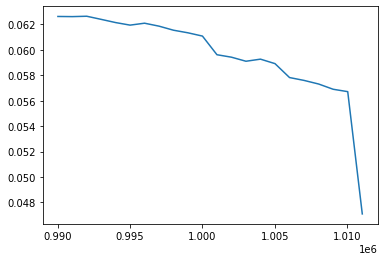

KKs 3


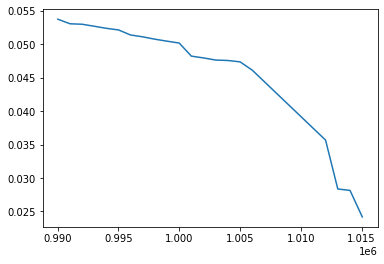

KUG 1210+301B (KK98 127)


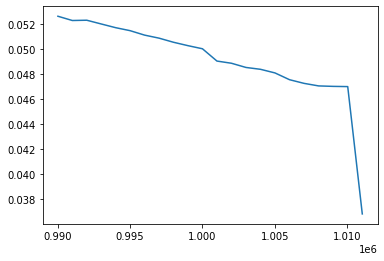

Lacerta I (Andromeda XXXI)


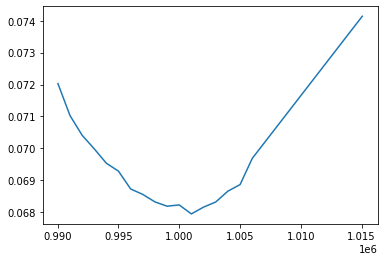

Large Magellanic Cloud (LMC)


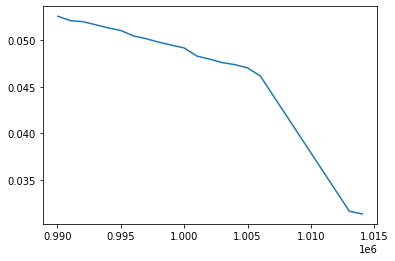

Leo A (Leo III, DDO 69)


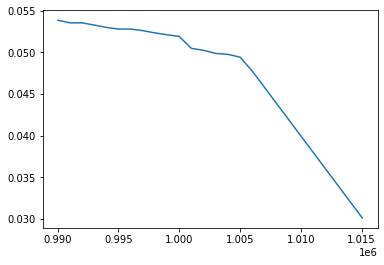

Leo I Dwarf (DDO 74, UGC 5470)


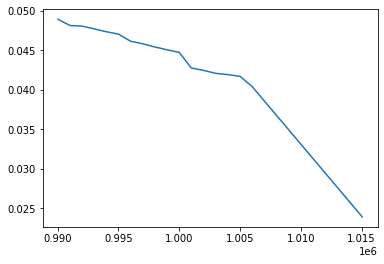

Leo II Dwarf (Leo B, DDO 93)


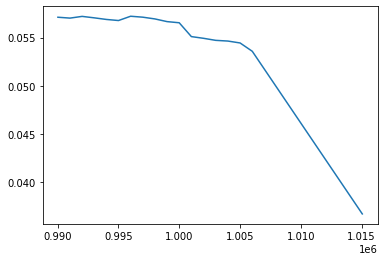

Leo IV Dwarf


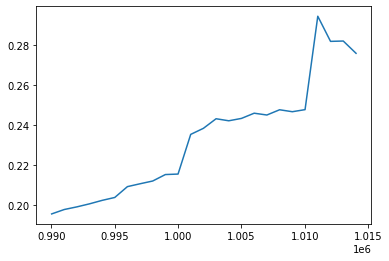

Leo P


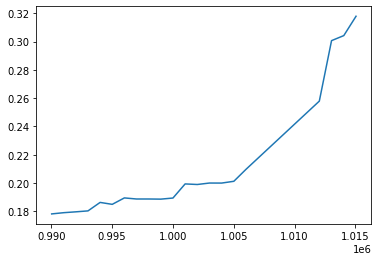

Leo T Dwarf


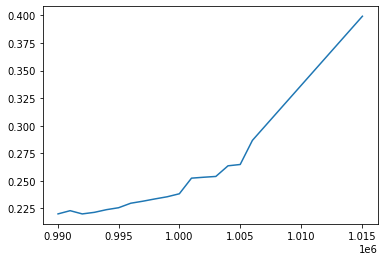

Leo V Dwarf


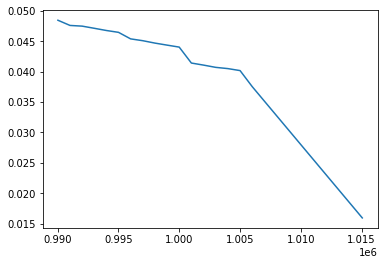

M110 (NGC 205)


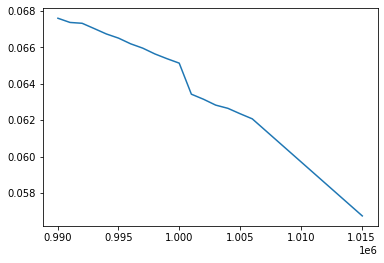

M32 (NGC 221)


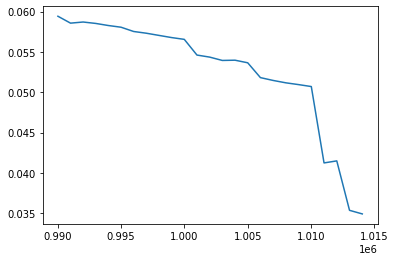

MB 1 (KK98 21)


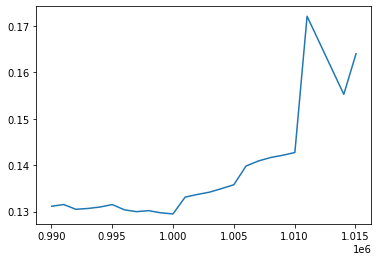

MB 3


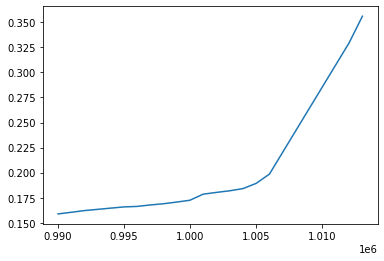

Maffei 1


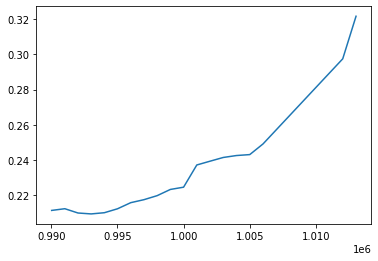

Maffei 2


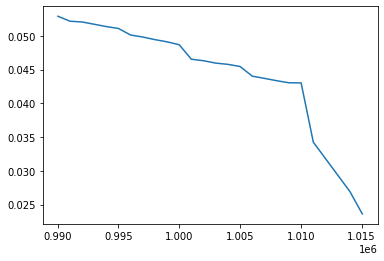

NGC 147 (DDO 3)


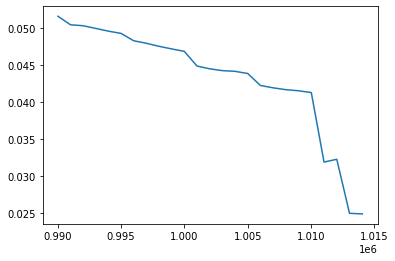

NGC 1560


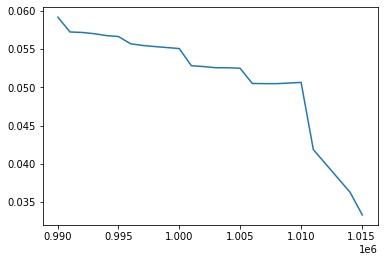

NGC 1569 (UGC 3056)


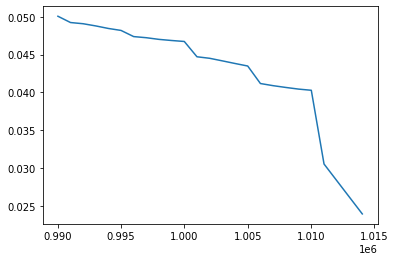

NGC 185


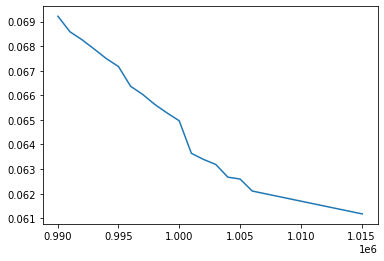

NGC 2366


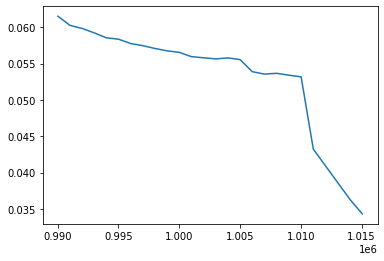

NGC 2403


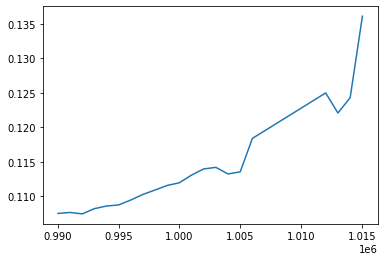

NGC 247


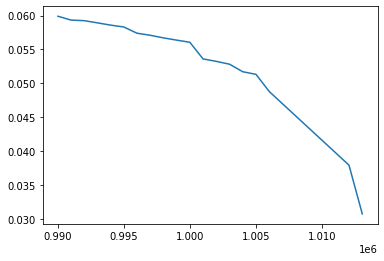

NGC 300


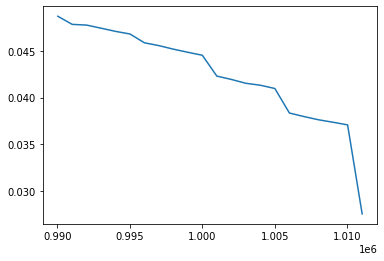

NGC 3109


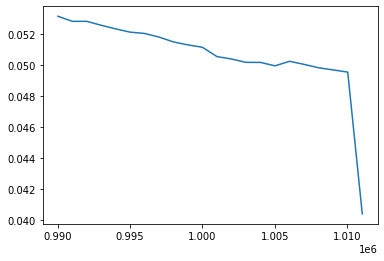

NGC 3741


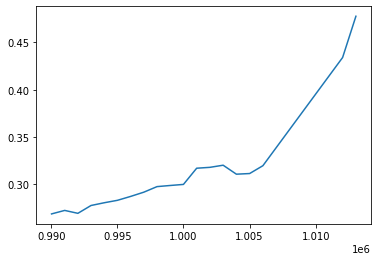

NGC 404


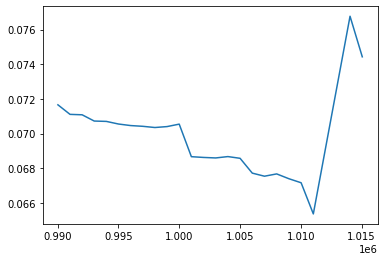

NGC 4163 (NGC 4167)


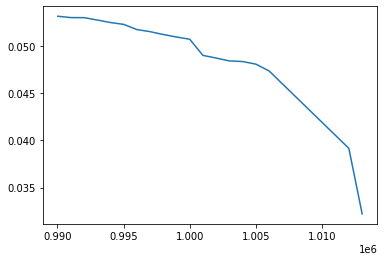

NGC 4214 (UGC 7278)


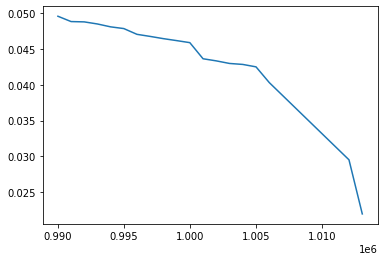

NGC 5102


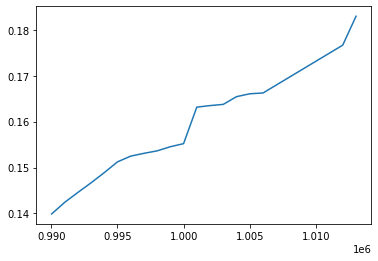

NGC 5206


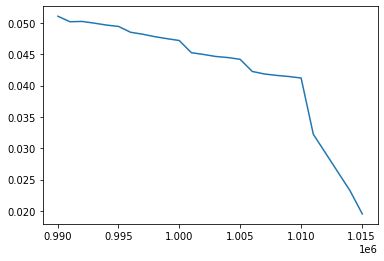

NGC 5237


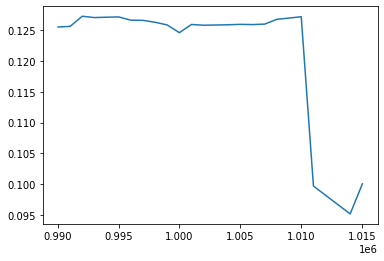

NGC 5253


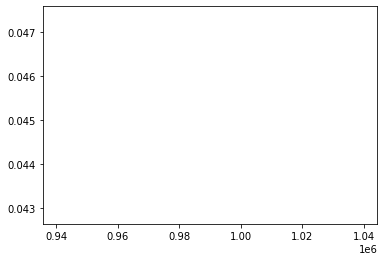

NGC 55


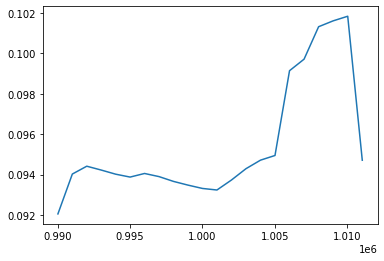

Pegasus Dwarf Irregular (DDO 216)


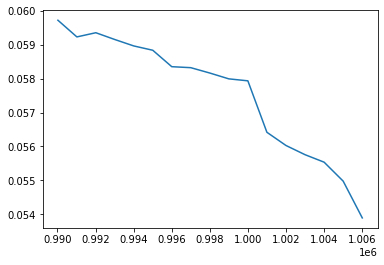

Pegasus Dwarf Sph (And VI)


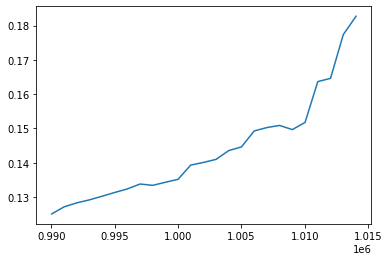

Pegasus III


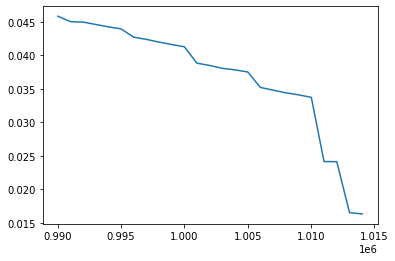

Perseus I (Andromeda XXXIII)


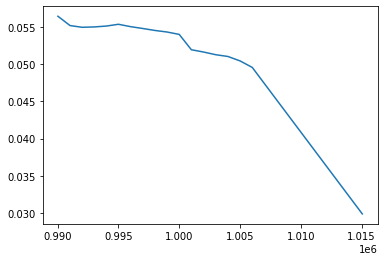

Phoenix Dwarf Galaxy (P 6830)


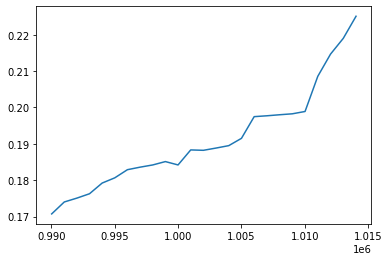

Phoenix II


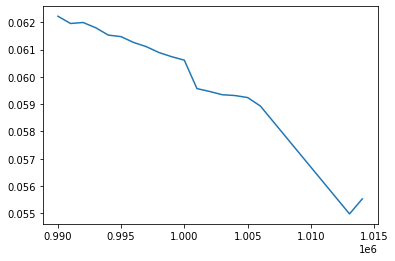

Pictor II


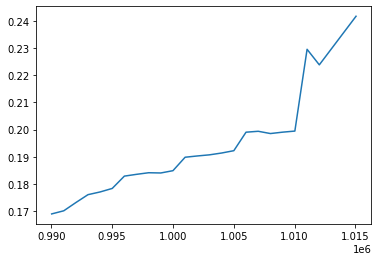

Pisces Dwarf


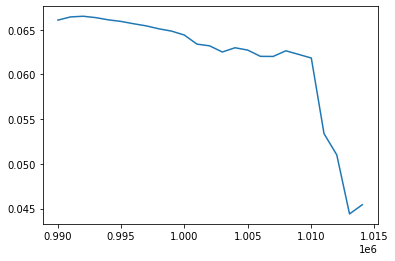

Pisces I


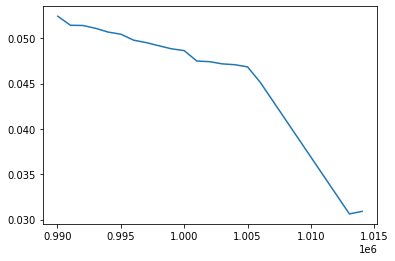

Pisces II


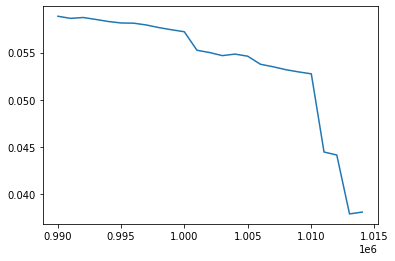

Pisces III (Andromeda XIII)


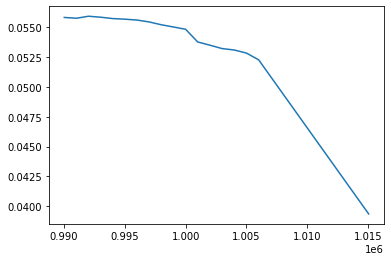

Pisces IV (Andromeda XIV)


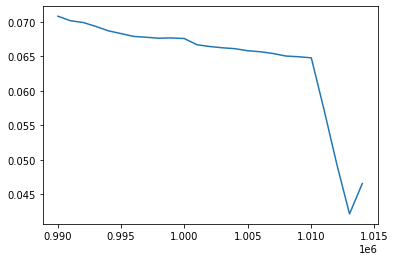

Pisces V (Andromeda XVI)


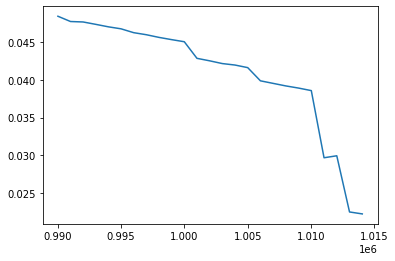

Reticulum II


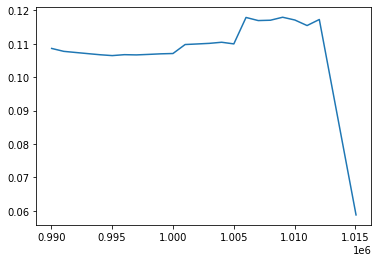

Reticulum III


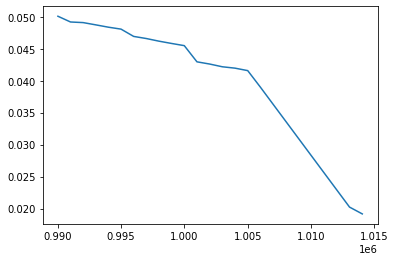

Sagittarius Dwarf Irregular Galaxy (SagDIG)


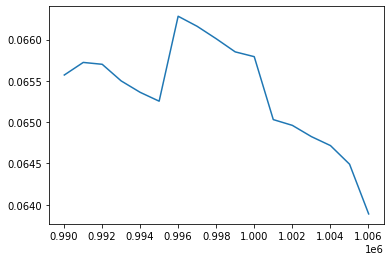

Sagittarius Dwarf Sphr SagDEG


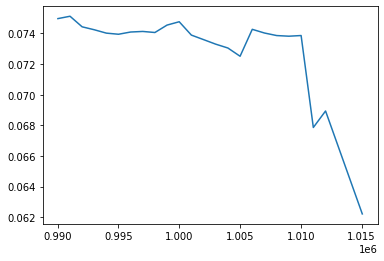

Sagittarius II


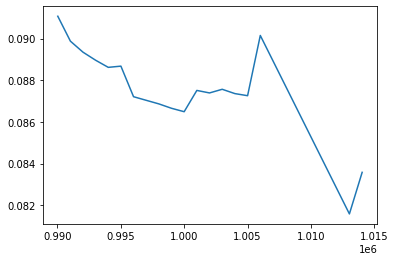

Sculptor Dwarf (E351-G30)


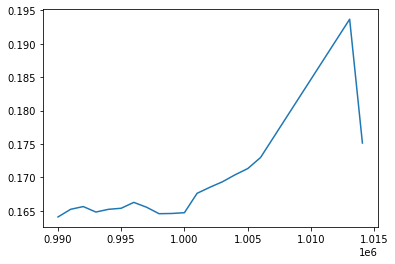

Segue 1


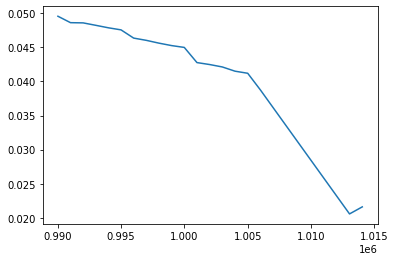

Segue 2


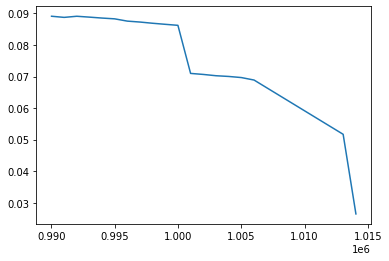

Sextans A (92205, DDO 75)


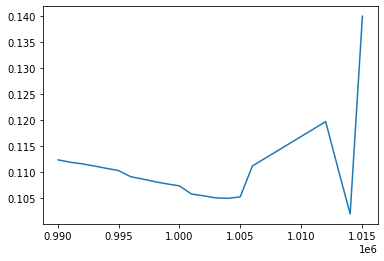

Sextans B (UGC 5373)


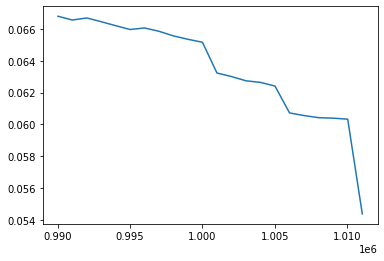

Sextans Dwarf Sph


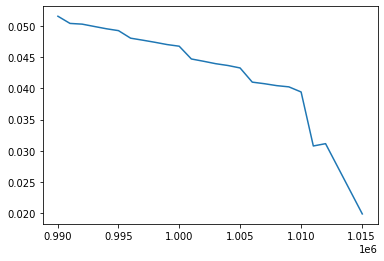

Small Magellanic Cloud (SMC, NGC 292)


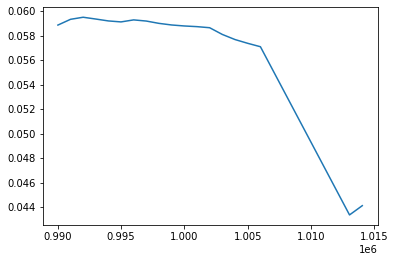

Triangulum Galaxy (M33)


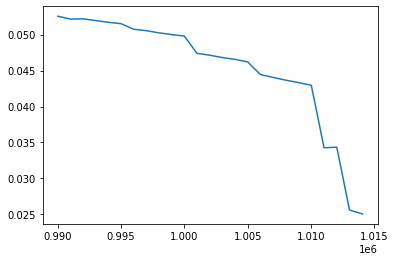

Triangulum II


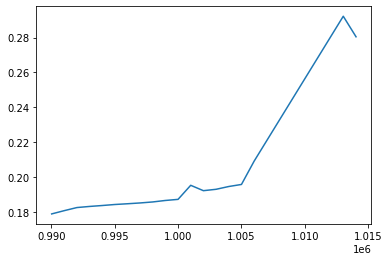

Tucana Dwarf


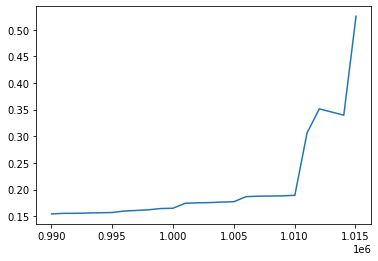

Tucana II


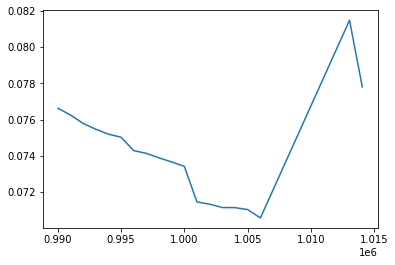

Tucana III


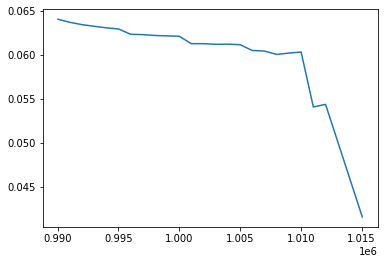

Tucana IV


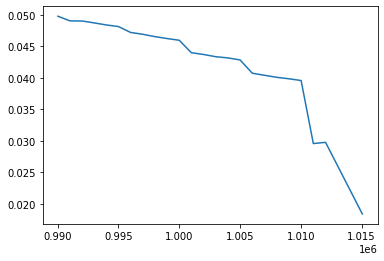

UGC 4483


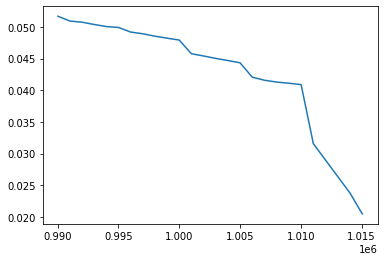

UGC 4879 (VV124)[61]


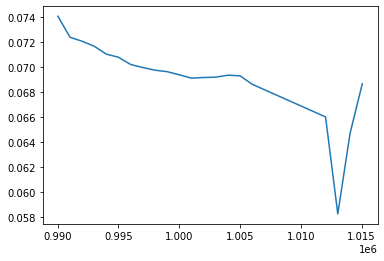

UGC 7577 (DDO 125)


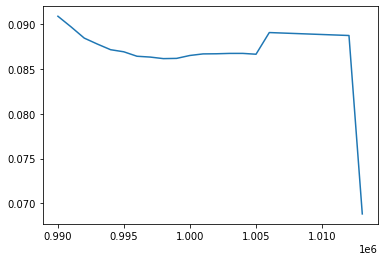

UGC 8508 (I Zw 060)


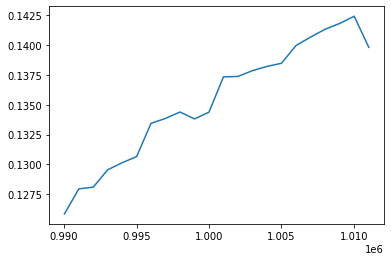

UGC 8651 (DDO 181)


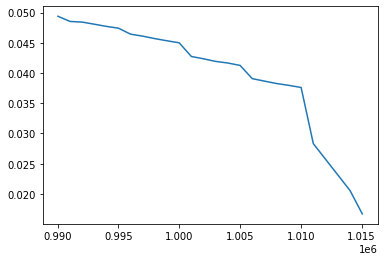

UGC 8833


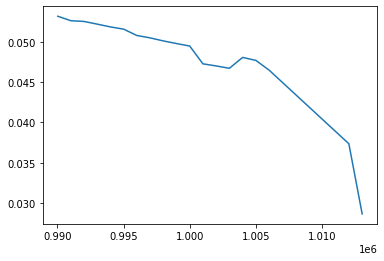

UGC 9128 (DDO 187)


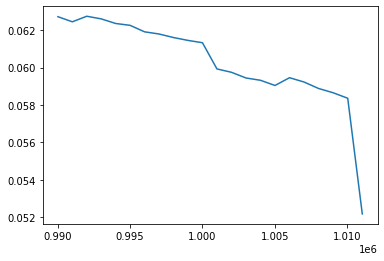

UGC 9240 (DDO 190)


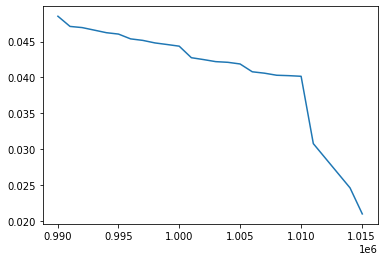

UGCA 105


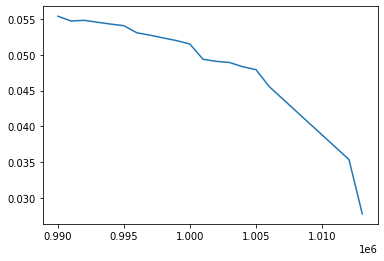

UGCA 133 (DDO 44)


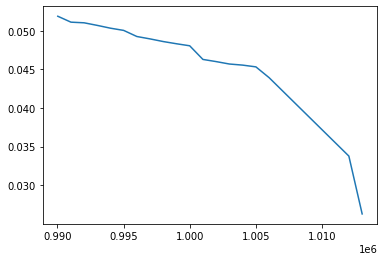

UGCA 15 (DDO 6)


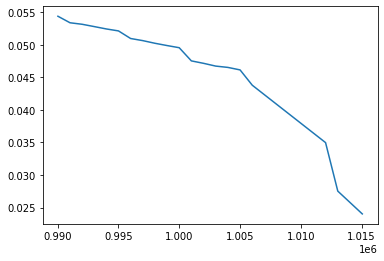

UGCA 276 (DDO 113)


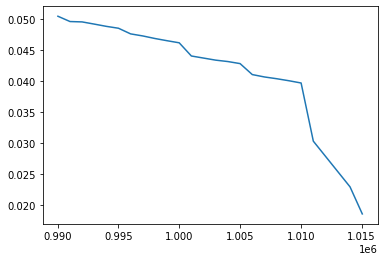

UGCA 292


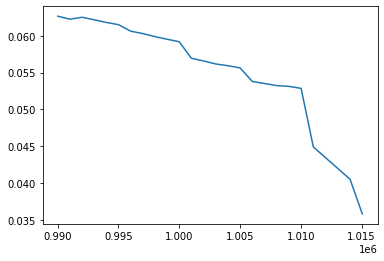

UGCA 438 (ESO 407-018)


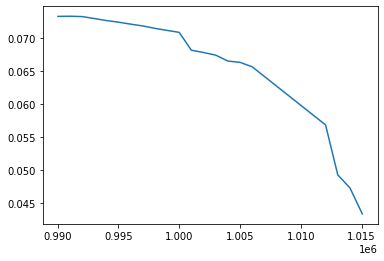

UGCA 86


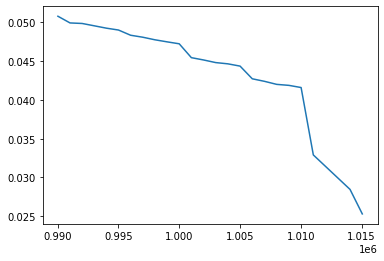

UGCA 92


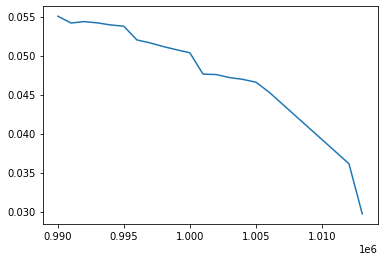

Ursa Major I Dwarf (UMa I dSph)


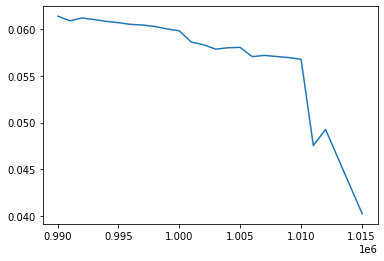

Ursa Major II Dwarf


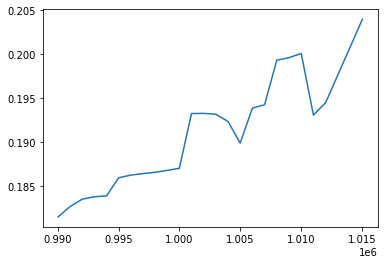

Ursa Minor Dwarf


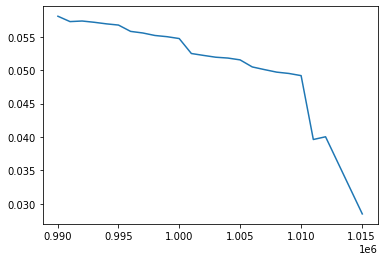

Virgo I


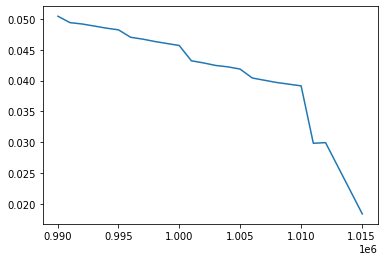

Willman 1


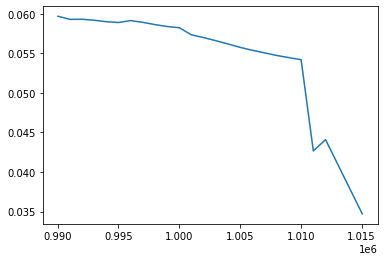

Wolf-Lundmark-Melotte (WLM, DDO 221)


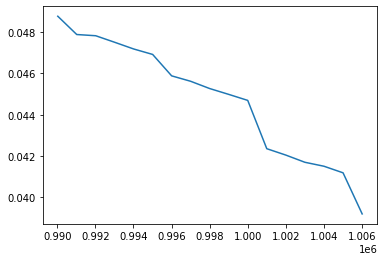

In [13]:
for name,grp in all_df.groupby("galaxy"):
  print(name)
  plt.plot(grp["galactic year"],grp.y)
  plt.show()

## Notes:

This is a very basic EDA, during the hackathon we had a lot of time to explore the details but in this notebook we included the most important parts only.

Here are some important  notes to take from this short dataset exploration:

- We cannot drop columns with missing values, we would loose to much data and information that could be useful to a model

- Y is very dependent on the galactic year if you look at it from a galaxy perspective (grouping by galaxy), in fact our first models used cubic splines to predict missing years in test data. so we built a model for each galaxy (a simple decision tree regressor, we avoided complex models because we had only 24-27 points by galaxy). This approach along with a good 2nd task can achieve a score on the LB upto 0.045 (using only galactic year as feature), which is quite weird actually, but some teams did this.

# Preprocessing

We talked about outliers, missing values and other aspects of the dataset, we will now work our way through handling these issues properly in order to increase the power of our predictive models. 

## Handling Missing values

There are many ways to fill missing values, our team used galaxy wide interpolation thorugh `df.groupby` followed by `df.interpolate` for each galaxy grp. after that we had some missing values left so we filled them with the mean of the galaxy. 

Another useful way is to use IterativeImputer (or MICE) to impute missing values **by galaxy**

In [14]:
def fill_na_mean_grp(df,cols):
  # Fill grp with interpol + mean of group
  cols.remove("galaxy")
  for col in cols:
    df[col] = df.groupby("galaxy")[col].transform(lambda x: x.interpolate(method="linear",limit_direction="both"))
    # filling left nan with mean of galaxy
    df[col] = df.groupby("galaxy")[col].transform(lambda x: x.fillna(x.mean()))
  return df

In [15]:
all_df = fill_na_mean_grp(all_df,all_df.columns.to_list())

print(all_df.isna().sum())

index                                                                           0
galactic year                                                                   0
galaxy                                                                          0
existence expectancy index                                                      1
existence expectancy at birth                                                   1
                                                                             ... 
Adjusted net savings                                                          493
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total    1185
Private galaxy capital flows (% of GGP)                                       441
Gender Inequality Index (GII)                                                 471
y                                                                               0
Length: 81, dtype: int64


## Dealing with outliers

We tried using robust scaler, but the CV score didn't improve so we decided to not use it. However we removed all negative values and we converted them to 0 using `df.clip(lower=0)`

In [16]:
def rem_neg_values(df,cols):
  cols.remove("galaxy")
  for col in cols:
    df[col] = df[col].clip(lower=0)
  return df

In [25]:
all_df = rem_neg_values(all_df,all_df.columns.to_list())

## Feature Engineering

Feature engineering was very important in this competition and we took 3 different approachs:

- Using an autoencoder with no feature engineering to find the best possible representation and reducing features from 80 to 20 new features

- Using all features after preprocessing, as we lacked domain knowledge and the dataset was relatively small.

- Add new statistical features and lag feature per galaxy.

For each approach, we built a seperate stacked model and did some fine tuning for the parameters. we will talk about  features more in the modeling part.![Texte alternatif…](https://)

## Dealing with the "Galaxy" feature

The target is very dependent on two features: galactic year and galaxy, besides that, the whole dataset was structured into galaxies, so it would have been very weird to remove this feature, we simply used One Hot Encoder on 2/3 models and a Label Encoder on another model:




In [26]:
from sklearn.preprocessing import LabelEncoder

def one_hot_encode(df):
  return pd.get_dummies(df)

def label_encode(df):
  galaxies = df["galaxy"]
  le = LabelEncoder()
  df["gal_cat"] = le.fit_transform(galaxies)
  return df

In [28]:
all_df1 = one_hot_encode(all_df)

## Things that didn't help

During the hackathon, we tried several approach in data preprocessing, here's a short list of things we thought that they would help but they didnt:

- Normalizing data didn't help at all, cv RMSE was only increasing

- Lag features did help but not much, so we didn't bother with it much at the end and we removed it from our final model.

-  Adding mean of closest 5 galaxies for each feature didn't help too

- Imputation using KNN increased slightly the error



# Modeling

During this hackathon we tried several models, here's the list of models we tried from the least performing to the most performing one.

- Building a seperate simple model for each galaxy
- Using an autoencoder to reduce dimensions (and noise) and then use light gbm with random search.

- Creating one stacked model on the autoencoded version of the dataset

- Building 3 stacked models and blending them (using geometric mean).



In this notebook we will discuss the three models we built. Cross validation is integrated into vecstack, so we used this implementation to achieve KFold out of fold cross val.

## 1st model: Autoencoder + Stacking

Autoencoder can learn a good representation of the data, thus reducing the noise.

The autoencoder code won't be shared here since it's not well structured yet, but we use 3 layers in the encoding part and 3 layers in the decoding part, then we used directly the encoder part to reduce number of features from 80 to 20. 

We then generated a new dataset called encoded_train and encoded_test from the encoded features and trained several stacked models: *Lasso, KNN Regressor, LGBM Regressor, XGB Regressor, Catboost Regressor, Random forest and extra trees were used too along with a simple linear regression.*

We used a very practical library called vecstack, here's the code: 





In [25]:
train_ae = pd.read_csv("encoded_train.csv")
test_ae = pd.read_csv("encoded_test.csv")

In [ ]:
X = train_ae.drop(["y",'galaxy'],1)
y = train_ae["y"]
X_train,X_test,y_train,y_test = train_test_split(X,y) 

In [25]:
#from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import RidgeCV
estimators_1 = [
    ('xgb', XGBRegressor(gamma= 0.5,learning_rate= 0.2,max_depth= 3,min_child_weight= 1,objective ='reg:squarederror')),
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(bootstrap= True,max_depth= 20,max_features= 8,min_samples_leaf= 3,min_samples_split= 2,n_estimators= 300)),
    ('lgb', LGBMRegressor(learning_rate=0.1,max_depth=3,num_leaves=10,min_child_sample=1)),
    ('lasso', Lasso(alpha=0.047)),
    ('knnr', KNeighborsRegressor()),
    ('cat', CatBoostRegressor(logging_level='Silent',learning_rate=0.03)),
    ( 'ExtraTR',ExtraTreesRegressor(n_estimators=110,max_depth=10 )),
]

stack = StackingTransformer(estimators_1, regression=True, verbose=2, shuffle=True)
stack = stack.fit(X_train, y_train)
S_train = stack.transform(X_train)


final_estimator = CatBoostRegressor(n_estimators=1500, max_depth=5,learning_rate=0.02)
final_estimator = final_estimator.fit(S_train, y_train)

S_test = stack.transform(new_test.drop('galaxy',1))
pred = final_estimator.predict(S_test)
y_1 = pred

## 2nd Model: All Features + Stacking

This is the most simple model and the least performing one (but not that bad, alone you can get a score of 0.03X on LB), we used all features + one hot encoding the galaxy feature.

This model includes: LGBM, XGboost, Randomforest, Lasso, Linear Regression and SVR. 

We are using a fine tuned XGBoost model for our stacking


In [29]:
train_2 = all_df1[:len(train)]
test_2 = all_df[len(train):]

In [30]:
X2 = train_2.drop(["y"],1)
y2 = train_2["y"]

In [32]:
print(X2.shape)

(3865, 260)


In [33]:
from sklearn.model_selection import train_test_split
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,test_size=0.25)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

estimators_1 = [
    #('xgb', XGBRegressor(objective ='reg:squarederror')),
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(max_depth=20,max_features=8,min_samples_leaf=3,min_samples_split=8,n_estimators=100)),
    ('lgb', LGBMRegressor(max_depth=5,num_leaves=30,min_data_in_leaf=5)),
    ('svr', SVR()),
    ('lasso', Lasso()),
    ('cat', CatBoostRegressor(logging_level='Silent',max_depth=5,learning_rate=0.03,n_estimators=1000)),
 
]

stack = StackingTransformer(estimators_1, regression=True, verbose=2, shuffle=True)
stack = stack.fit(X_train2, y_train2)
S_train = stack.transform(X_train2)


final_estimator = XGBRegressor()
final_estimator = final_estimator.fit(S_train, y_train2)

S_test = stack.transform(test_2)

pred = final_estimator.predict(S_test)
y2 = pred

## 3rd Model: Statistical features  + Stacking

Our 3rd and last model consists in adding mean, max, min and std of each feature for each galaxy + OHE for the galaxy feature, this was our 2nd best model, we had around 581 features so we used almost the same architecture as the previous model along with fine tuned xgboost as a meta regressor

In [ ]:
# Creating thenew features

def get_stats_features(grp,cols=[]):
  cols = grp.columns.to_list()
  cols.remove("galaxy")
  for col in cols:
    grp[col + "_mean"]= grp[col].mean()
    grp[col + "_max"] = grp[col].max()
    grp[col + "_min"] = grp[col].min()
    grp[col + "_std"] = grp[col].std()
  return grp

all_df3 = all_df.groupby("galaxy",group_keys=False).apply(get_stats_features)

In [ ]:
train_3 = all_df3[:len(train)]
test_3  all_df3[len(train):]


In [ ]:
X3 = new_train3.drop("y",1)
y3 = new_train3["y"]

In [ ]:
X_train3,X_test3,y_train3,y_test3 = train_test_split(X3,y3,test_size=0.25,random_state=0)

In [ ]:
# Building the 3rd model

estimators_1 = [
    ('xgb', XGBRegressor(objective ='reg:squarederror')),
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor()),
    ('lgb', LGBMRegressor(max_depth=5,num_leaves=30,min_data_in_leaf=5)),
    ('svr', SVR()),
]

stack = StackingTransformer(estimators_1, regression=True, verbose=2, shuffle=True)
stack = stack.fit(X_train3, y_train3)
S_train = stack.transform(X_train3)

final_estimator = XGBRegressor(max_depth=3,learning_rate=0.1,n_estimators=1000)
final_estimator = final_estimator.fit(S_train, y_train)



In [ ]:
S_test = stack.transform(test_3)

pred = final_estimator.predict(S_tes)
y3 = pred

## Final Predictions:

Our final predictions is the geometric mean between $y_1$ , $y_2$ and $y_3$. thus it's given by 

$$ y_f = geoAvg(y_1,y_2,y_3) = (y_1 \circ y_2 \circ y_3)^{1/3}$$

In [ ]:
y_result = np.power(y1*y2*y3,1/3)

## Public LB - Private LB Drop

We got a relatively big drop in ranking from 4th to 25th place in private LB, and this is due to the fact that we used several blending levels with other submission files we had.Which might have caused some overfitting along with the strategy we followed on 2nd task. But in overall we're happy with our ranking since it's our first data science hackathon and some teams had bigger drops in ranking. 